最后，通过封装好的框架，建立一个基准模型

In [1]:
import os
os.chdir('d:/future/panel_informer')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
feature = pd.read_csv('data/feature.csv', index_col='Unnamed: 0')
feature.dropna(inplace=True)
feature = feature.set_index('trade_date')
for i in feature.columns:
    feature[i] = (feature[i] - feature[i].mean())/ feature[i].std()

label = pd.read_csv('data/label.csv', index_col='Unnamed: 0')
label = label.set_index('trade_date')
data = pd.concat([feature, label], axis = 1)

In [3]:
from utils.random_split import RandomSplit

data_set = RandomSplit(data, 'cuda:0')
data_set.set_output(feature.columns, dtype = torch.float32, unfold = True)
data_set.set_output(['ch_next_week', 'down_probability', 'middle_probability', 'up_probability'], dtype = torch.float32, unfold = False)
train_set, validation_set, test_set = data_set.get_split_data(700, 250, 250, 30)

In [4]:
label.describe()

,ch_next_week,alter_std,down_probability,middle_probability,up_probability
count,1859.000000,1860.000000,1.859000e+03,1859.000000,1.859000e+03
mean,0.788667,79.000000,3.234378e-01,0.350571,3.259911e-01
std,79.631744,34.649708,2.629507e-01,0.169994,2.600157e-01
min,-376.128300,25.596879,2.106471e-09,0.000014,2.905489e-09
25%,-42.558550,53.500076,1.049049e-01,0.239887,1.051040e-01
50%,0.453600,73.459044,2.723034e-01,0.342380,2.724897e-01
75%,45.083600,95.088000,4.880362e-01,0.457958,5.006309e-01
max,512.379500,300.223384,9.999566e-01,0.882132,9.999859e-01


In [5]:
from utils.hybrid_loss import HybridLoss
loss_fn = HybridLoss(alpha = 1e-3, delta = 1)

In [6]:
from utils.prediction_recorder import PredictionRecorder
recorder = PredictionRecorder(is_logits = True)

In [7]:
import matplotlib.pyplot as plt

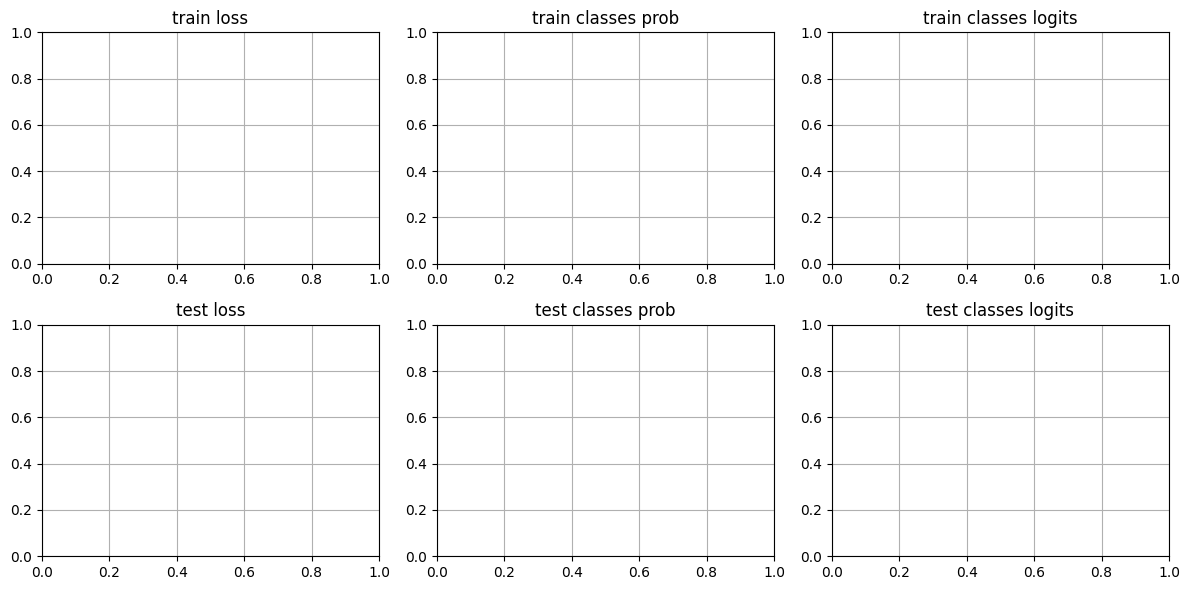

In [8]:
from utils.train_animator import TrainAnimator
animator = TrainAnimator(figsize=(12,6))

In [9]:
from utils.hybrid_decoder import HybridDecoder

class Baseline_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, hidden_size,num_layers, dropout, **kwargs):
        super(Baseline_LSTM, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.process = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.output = HybridDecoder(dim_state = hidden_size)

    def forward(self, x):
        random_drop = np.random.randint(0, 20)
        x = x[:,random_drop:,:]
        return self.output(self.process(x)[0][:,-1,:])

In [10]:
model = Baseline_LSTM(input_size = 17,
                      hidden_size = 17 * 2,
                      num_layers = 1,
                      dropout = 0.5,
                      ).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 1e-1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


c:\Users\Ferdinand\.conda\envs\future\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


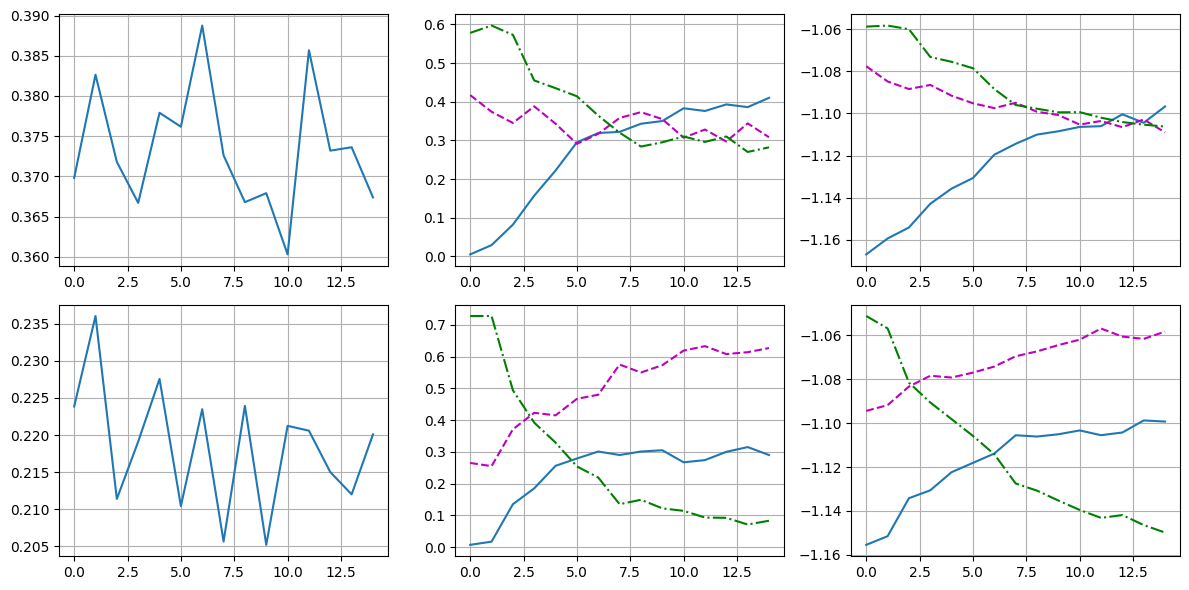

100%|██████████| 100/100 [00:00<00:00, 590.83it/s]


In [11]:
from utils.model_train import ModelTrain
train = ModelTrain(model = model,
                   train_set = train_set,
                   validation_set=validation_set,
                   test_set=test_set,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler=scheduler,
                   recorder=recorder,
                   graph=animator,
                   threshold = 45,
                   )
train.epoch_train(epochs = 30, round = 100, early_stop = 10)

In [12]:
train.round(round = 100, is_train = False, use_set = 'train', print_summary = True)

100%|██████████| 100/100 [00:00<00:00, 530.16it/s]


,预测为该分类的个数,Precision (精确率),真实为该分类的个数,Accuracy (召回率),Severe (严重错误率)
分类 0 (负),387,0.428941,305,0.544262,0.235142
分类 1 (放弃),327,0.541284,426,0.415493,0.000000
分类 2 (正),286,0.346154,269,0.368030,0.237762
总计,1000,0.442000,1000,0.442000,0.159000


In [13]:
train.round(round = 100, is_train = False, use_set = 'test', print_summary = True)

100%|██████████| 100/100 [00:00<00:00, 541.45it/s]


,预测为该分类的个数,Precision (精确率),真实为该分类的个数,Accuracy (召回率),Severe (严重错误率)
分类 0 (负),410,0.263415,193,0.559585,0.151220
分类 1 (放弃),481,0.659044,624,0.508013,0.000000
分类 2 (正),109,0.247706,183,0.147541,0.137615
总计,1000,0.452000,1000,0.452000,0.077000


In [14]:
# torch.save(model.state_dict(), 'params/baseline.params')

In [15]:
from utils.random_split import RandomSplit

data_set = RandomSplit(data, 'cuda:0')
data_set.set_output(feature.columns, dtype = torch.float32, unfold = True)
data_set.set_output(['ch_next_week', 'down_probability', 'middle_probability', 'up_probability'], dtype = torch.float32, unfold = False)
train_set, validation_set, test_set = data_set.get_split_data(700, 250, 250, 30)

In [16]:
from utils.back_test import BackTest
BackTest(*test_set.all())

AttributeError: 'CallableDataset' object has no attribute 'all'